## This notebook illustrates how to build a `U-Net`  model for image segmentation.
- This architecture is made up of fully convolution neural networks.

- The key difference between the `FCN-8` and `U-Net` is that `U-Net` uses skip connections from the encoder to the decoder.

- This model is responsible for predicting pixels of an input image that are part of the background. foreground and its outline.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

2022-09-17 17:23:46.179943: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-17 17:23:46.342392: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-17 17:23:46.342415: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-17 17:23:46.377631: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-17 17:23:47.303960: W tensorflow/stream_executor/pla

## The dataset used for training this model is known as the [`Oxford Pets - IIT dataset.`](https://www.robots.ox.ac.uk/~vgg/data/pets/)

In [2]:
# download the dataset and get info
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

2022-09-17 17:23:54.934486: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete6IHJO8/oxford_iiit_pet-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete6IHJO8/oxford_iiit_pet-test.tfrecord*...:   0%…

Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


2022-09-17 17:25:30.876051: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-17 17:25:30.876085: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-17 17:25:30.876105: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-39-35): /proc/driver/nvidia/version does not exist
2022-09-17 17:25:30.876369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#See the possible keys we can access in the dataset's dict.
print(dataset.keys())

dict_keys(['train', 'test'])


## Prepare the dataset.
The following utility functions are used to prepare the dataset:
- Simple augmentation by flipping the image.
- Normalizing the pixel values.
- Resizing the images.


| Label         | Class name|
|--------------- |------------------|
|1                  | Foreground|
|2                  | Background|
|3                  | Not classified|


<br>
<br>

For convenience, we will subract `1` from these values and we will interpret these as `{'pet', 'background', 'outline'}`:

| Label            | Class Name     |
| -------------    | -------------  |
| 0                | pet            |
| 1                | background     |
| 2                | outline        |

In [4]:
def random_flip(input_image, input_mask):
    ''' Performs a random flip of the image and the mask.'''
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask

In [5]:
def normalize(input_image, input_mask):
    '''
    Function normalizes the input image pixel values in the range [0-1],
    subtracts 1 from the mask labels to have a range from [0-2]
    '''
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [6]:
@tf.function
def load_image_train(datapoint):
    '''resizes, normalizes and flips the training data.'''
    input_image = tf.image.resize(datapoint['image'], (128, 128), method = 'nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method = 'nearest')

    input_image, input_mask = random_flip(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [7]:
def load_image_test(datapoint):
    '''resizes and  normalizes the test data.'''
    input_image = tf.image.resize(datapoint['image'], (128, 128), method = 'nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method = 'nearest')

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

#### The dataset already contains the train and test splits. You will use those by accessing the `train` and `test` keys of the `dataset` dictionary.

#### The `tf.data.AUTOTUNE` value is passed to allow certain methods to automatically set parameters based on available resources. For instance, `num_parallel_calls` parameter is set dynamically based on the number of CPUs.

In [8]:
#Preprocess the train and test sets.
train = dataset['train'].map(load_image_train, num_parallel_calls = tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

BATCH_SIZE = 64
BUFFER_SIZE = 1000

#Shuffle and group the train set into batches.
train_dataset = (train
                 .cache()
                 .shuffle(BUFFER_SIZE)
                 .batch(BATCH_SIZE).repeat()
                 .prefetch(buffer_size = tf.data.AUTOTUNE))

#Group the test set into batches.
test_dataset = test.batch(BATCH_SIZE)

In [9]:
#Define utility functions for data visualization.
class_names = ['pet', 'background', 'outline']


def display_with_metrics(display_list, iou_list, dice_score_list):
    '''displays a list of images/masks and overlays a list of IoU and Dice scores.'''
    metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
    metrics_by_id.sort(key = lambda tup: tup[1], reverse = True) #Sorts in place.

    display_string_list = ["{}:  IoU:  {}  Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
    display_string = "\n\n".join(display_string_list)

    display(display_list, ['Image', 'Predicted mask', 'True mask'], display_string = display_string)


In [11]:
def display(display_list, titles = [], display_string = None):
    '''Displays a list of images/masks'''
    plt.figure(figsize = (15, 15))

    for item in range(len(display_list)):
        plt.subplot(1, len(display_list), item + 1)
        plt.title(titles[item])
        plt.xticks([])
        plt.yticks([])

        if display_string and item == 1:
            plt.xlabel(display_string, fontsize = 12)
        img_arr = tf.keras.preprocessing.image.array_to_img(display_list[item])
        plt.imshow(img_arr)

    plt.show()

In [12]:
def show_image_from_dataset(dataset):
    '''displays the first image and its mask from the dataset.'''

    for image, mask in dataset.take(1):
        sample_image, sample_mask = image, mask
    display([sample_image, sample_mask], titles = ['Image', 'True mask'])

In [13]:
def plot_metrics(metric_name, title, ylim = 5):
    '''Plots a given metric form the model history.'''
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(model_history.history[metric_name], color = 'blue', label = metric_name)
    plt.plot(model_history.history['val_' + metric_name], color = 'green', label = 'val_' + metric_name)

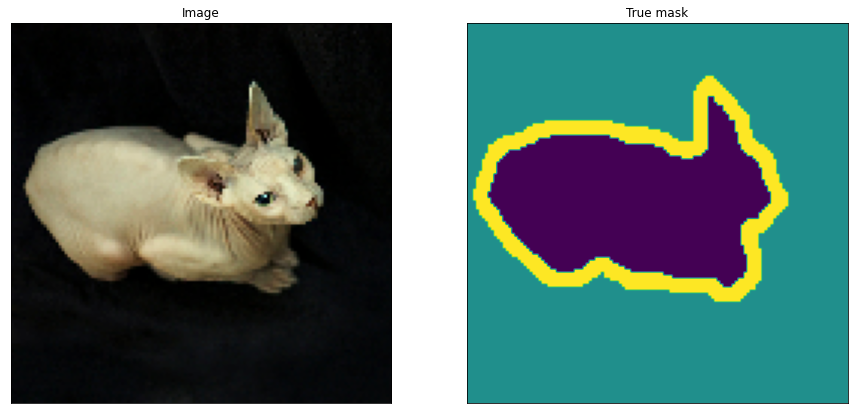

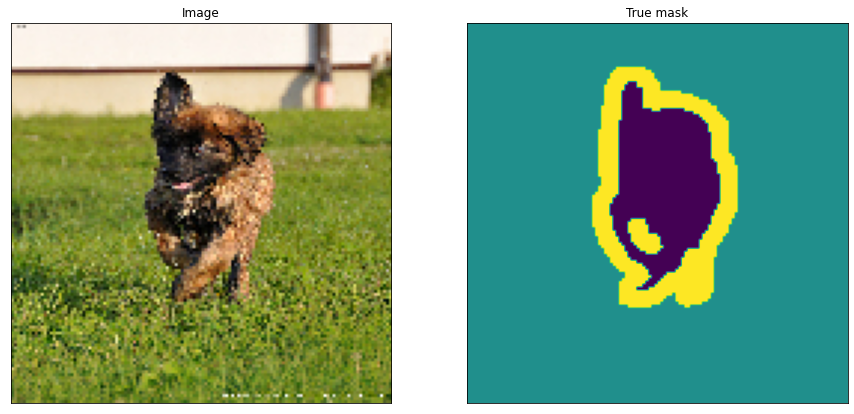

In [14]:
#Display an image from the train set.
show_image_from_dataset(train)

#Display an image from the test set.
show_image_from_dataset(test)

# Define the model.
***

### A `U-Net` consists of an `encoder `(downsampler) and a `decoder`(upsampler ) with  a bottlenck in between.

### The gray arrows corresponding to the skip connections that concatenate the encoder block outouts to each stage of the decoder.

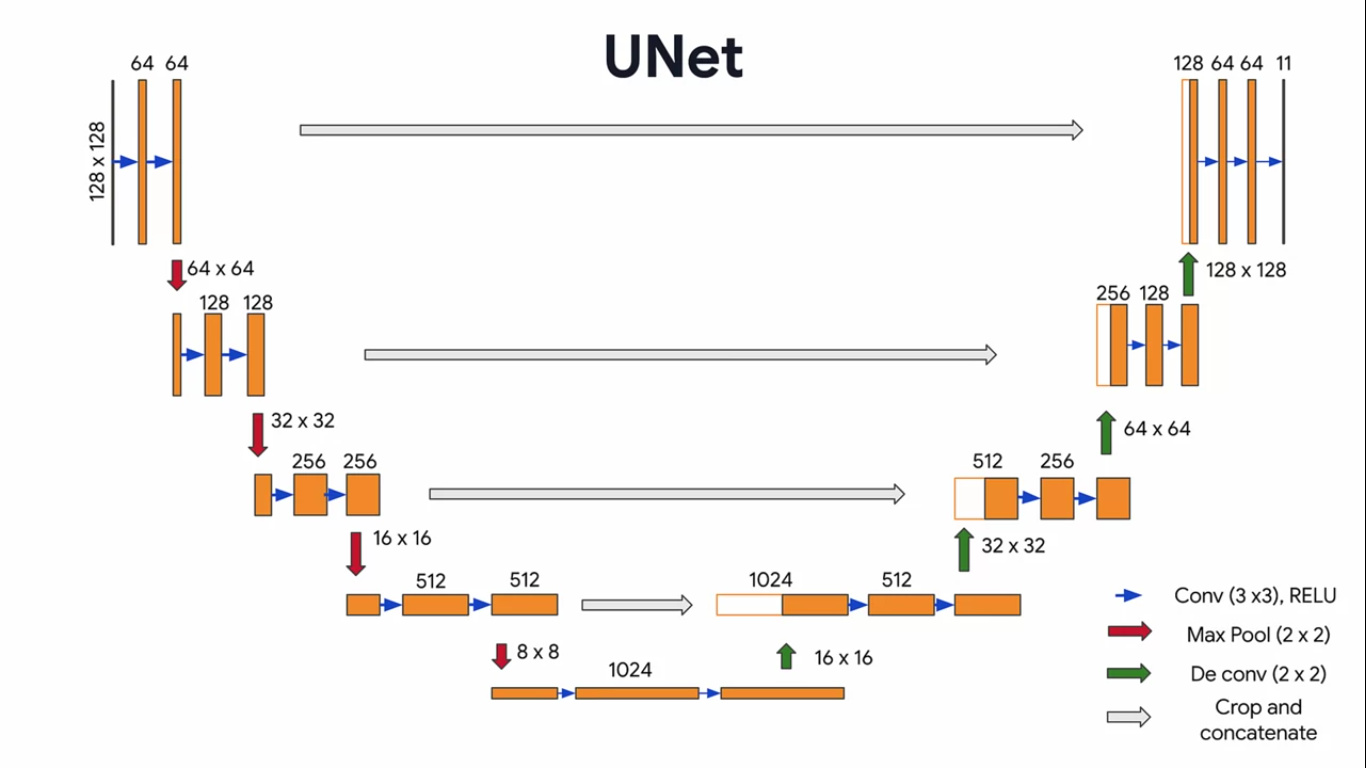

#### The encoder utilities will have 3 functions: 
- `conv2d_block()`. To add two convolutional layers and ReLU activations.

- `encoder_block()` To add pooling and dropout to the conv2d blocks. In U-Net you have to save the output of the convolutional layers at each block so this function will return two values to take that into account.

- `encoder()` To build the entire encoder.

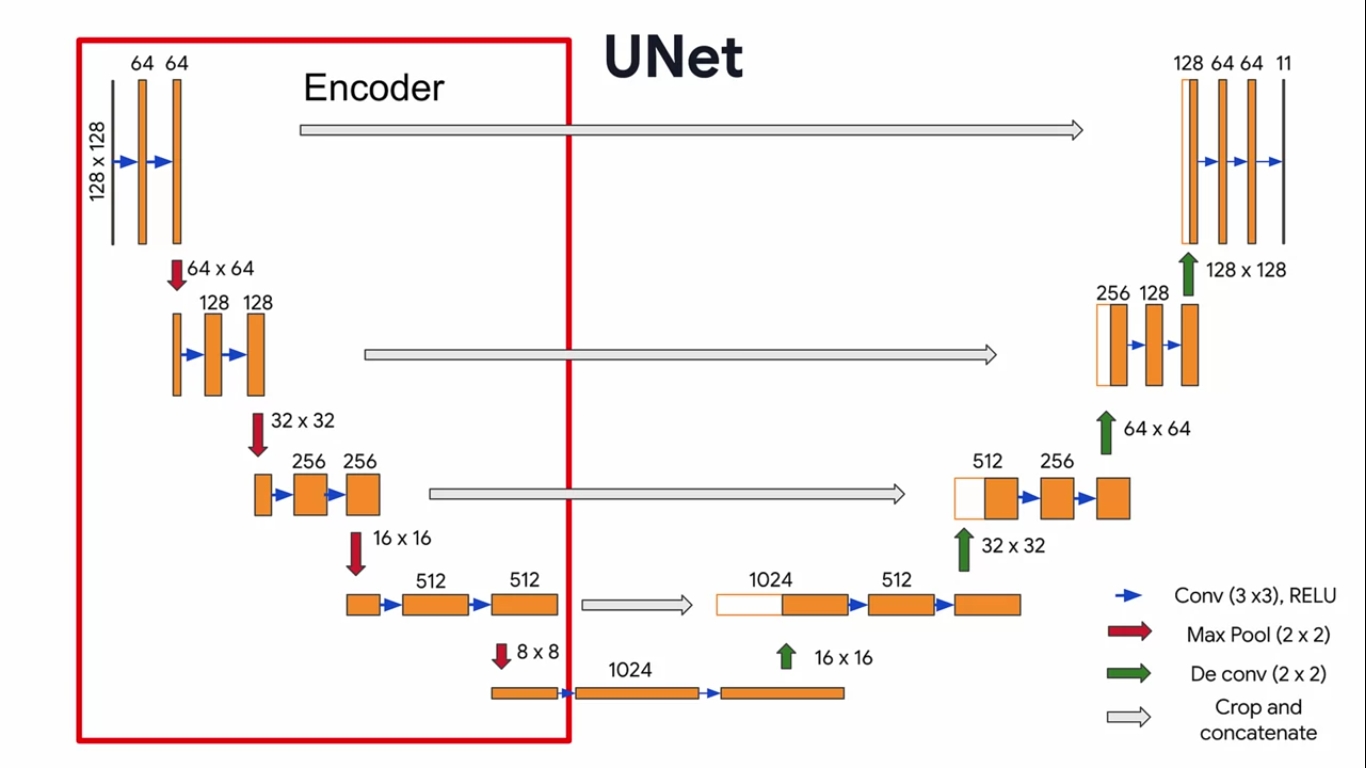

In [16]:
#Encoder utilities.
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  #First layer.
    x = input_tensor

    for item in range(2):
        x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
                                   kernel_initializer = 'he_normal', padding = 'same')(x)
        x = tf.keras.layers.Activation('relu')(x)

    return x


def encoder_block(inputs, n_filters = 64, pool_size = (2, 2), dropout = 0.3):
    '''
    Adds 2 convolutional blocks and performs downsampling on the output of convolutions.
    '''
    f = conv2d_block(inputs, n_filters = n_filters)
    p = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(f)
    p = tf.keras.layers.Dropout(0.3)(p)

    return f, p

def encoder(inputs):
    '''Function defines the downsampling path.'''
    f1, p1 = encoder_block(inputs, n_filters = 64, pool_size = (2, 2), dropout = 0.3)
    f2, p2 = encoder_block(p1, n_filters = 128, pool_size = (2, 2), dropout = 0.3)
    f3, p3 = encoder_block(p2, n_filters = 256, pool_size = (2, 2), dropout = 0.3)
    f4, p4 = encoder_block(p3, n_filters = 512, pool_size = (2, 2), dropout = 0.3)

    return p4, (f1, f2, f3, f4)

# Bottleneck.
***

#### A bottleneck follows the encoder block and is used to extract more features.

In [17]:
def bottleneck(inputs):
    '''
    This function defines the bottleneck convolutions to extract more features 
    before the upsampling layers.
    '''
    bottle_neck = conv2d_block(inputs, n_filters = 1024)

    return bottle_neck

# Decoder.
***
#### The decoder upsamples the features back to the original image size.

#### At each upsampling level, you will take the output of the corresponding encoder block and concatenate it before feeding it to the next decoder block.
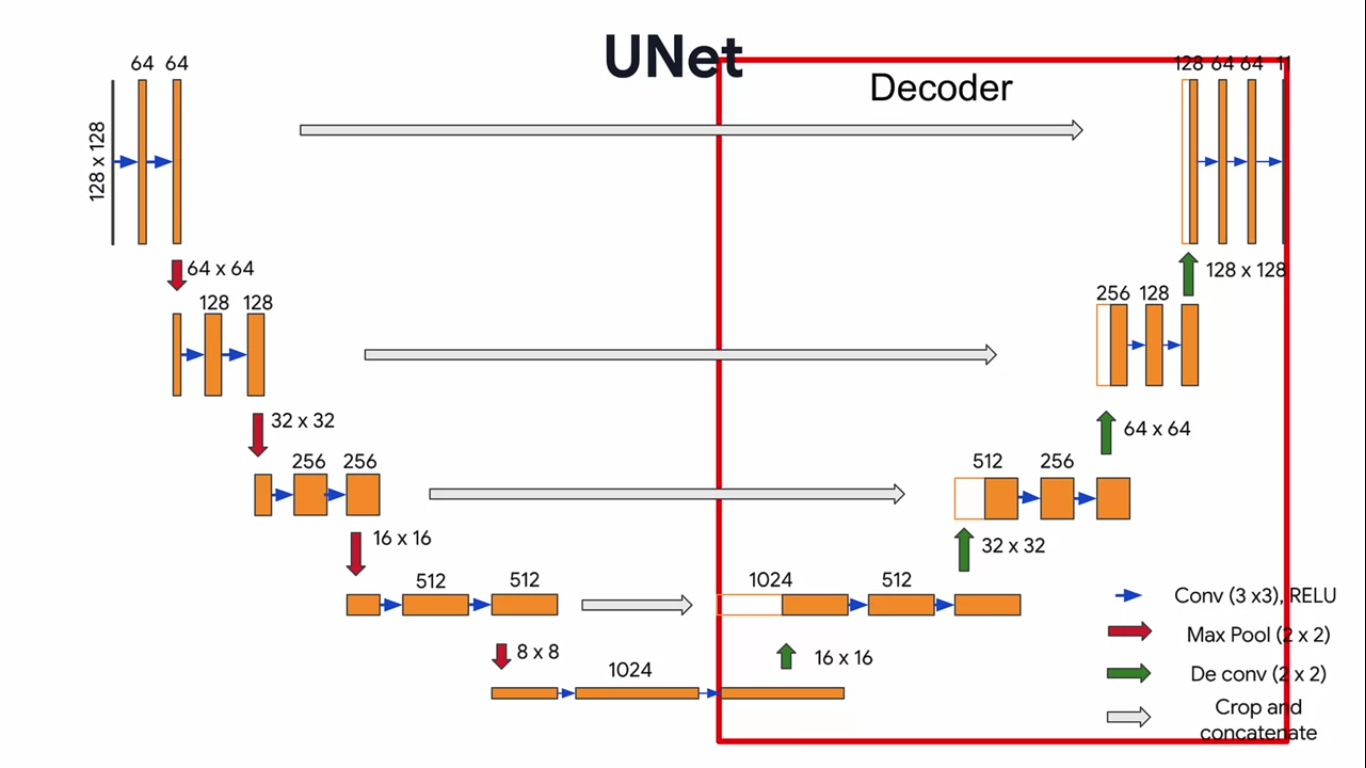

In [18]:
def decoder_block(inputs, conv_output, n_filters = 64, kernel_size = 3, strides = 3, dropout = 0.3):
    '''
    Defines the one decoder block of the U-Net.
    Args:
    inputs (tensor) --> Batch of the input features.
    conv_output (tensor) --> Features from an encoder block.
    n_filters (int) --> Number of filters.
    kernel_size (int) --> The kernel size.
    strides (int) --> Strides for deconvolution / upsampling.
    padding (string) --> "same" or "valid"  tells if the shape will be preserved by zero padding.
    '''
    u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
    c = tf.keras.layers.concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filters, kernel_size = 3)

    return c

In [19]:
def decoder(inputs, convs, output_channels):
    ''' Defines the decoder of the U-Net chaining together 4 decoder blocks.'''

    f1, f2, f3, f4 = convs

    c6 = decoder_block(inputs, f4,  n_filters = 512, kernel_size = (3, 3), strides = (2, 2), dropout = 0.3)
    c7 = decoder_block(c6, f3, n_filters = 512, kernel_size = (3, 3), strides = (2, 2), dropout = 0.3)
    c8 = decoder_block(c7, f2, n_filters = 512, kernel_size = (3, 3), strides = (2, 2), dropout = 0.3)
    c9 = decoder_block(c8, f1, n_filters = 512, kernel_size = (3, 3), strides = (2, 2), dropout = 0.3)

    outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation = 'softmax')(c9)

    return outputs

### Putting it all together.


We build the U-Net by chaining the encoder, bottleneck and decoder.

In [20]:
OUTPUT_CHANNELS = 3

def unet():
    '''Defines the U-Net by connecting the encoderm bottleneck and decoder.'''

    #Specify the input shape.
    inputs = tf.keras.Input(shape = (128, 128, 3, ))

    #Feed inputs to the encoder.
    encoder_output, convs = encoder(inputs)

    #Feed the encoder output to the bottleneck.
    bottle_neck = bottleneck(encoder_output)

    #Feed the bottleneck and encoder block outputs to the decoder and 
    #specify the number of classes through the output_channels argument.
    outputs = decoder(bottle_neck, convs, output_channels = OUTPUT_CHANNELS)

    #Create the model.
    model = tf.keras.Model(inputs, outputs)

    return model


#Instantiate model.
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                             

## Compile and train model.


#### The loss function used is `sparse_categorical_crossentropy` since the network is trying to assign each pixel a label, just like multi-class prediction.

In [21]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])


#Configure training parameters and train the model.
TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 10
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs = EPOCHS, 
                          steps_per_epoch = STEPS_PER_EPOCH, 
                          validation_steps = VALIDATION_STEPS,
                          validation_data = test_dataset)

Epoch 1/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2022-09-17 17:29:06.549930: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2147483648 exceeds 10% of free system memory.
2022-09-17 17:29:10.908834: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2415919104 exceeds 10% of free system memory.
2022-09-17 17:29:11.284916: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2415919104 exceeds 10% of free system memory.
2022-09-17 17:29:12.388423: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2415919104 exceeds 10% of free system memory.
2022-09-17 17:29:12.753821: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2415919104 exceeds 10% of free system memory.


11/57 [====>.........................] - ETA: 1:39:20 - loss: 2.3836 - accuracy: 0.5613

KeyboardInterrupt: 

### Plot the metrics.

In [ ]:
plot_metrics('loss', title = 'Training vs validation loss', ylim = 1)

### Make predictions.

In [ ]:
#Prediction utilities.

def get_test_image_and_annotation_arrays():
    '''Unpacks the test dataset and returns the input images and segmentation masks.'''
    ds = test_dataset.unbatch()
    ds = ds.batch(info.splits['test'].num_examples)

    images = []
    y_true_segments = []

    for image, annotation in ds.take(1):
        y_true_segments = annotation.numpy()
        images = image.numpy()

    y_true_segments = y_true_segments[ : (info_splits['test'].num_examples - (info.splits['test'.num_examples % BATCH_SIZE]))]

    return images[ : (info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments


def create_mask(pred_mask):
    '''Creates the segmentation mask by getting the channel with the highest probability.
    For each pixel, the prediction will be the channel with the highet probability.
    '''
    pred_mask = tf.argmax(pred_mask, axis = -1)
    pred_mask = pred_mask[. . ., tf.newaxis]

    return pred_mask[0].numpy()


def make_predictions(image, mask, num  = 1):
    '''Feeds an image to a model and returns the predicted mask.'''
    image = np.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]))
    pred_mask = model.predict(image)
    pred_mask = create_mask(pred_mask)

    return pred_mask

## Compute `class-wise` metrics (IoU and Dice Score)

In [ ]:
def class_wise_metrics(y_true, y_pred):
    class_wise_iou = []
    class_wise_dice_score = []
    smoothening_factor = 0.00001

    for item in range(3):
        intersection = np.sum((y_pred == item) * (y_true == item))
        y_true_area = np.sum((y_true == item))
        y_pred_area = np.sum((y_pred == item))
        combined_area = y_true_area + y_pred_area
        
        iou = (intersection + smoothening_factor) / (combined_area + smoothening_factor)
        class_wise_iou.append(iou)
        
        dice_score = 2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
        class_wisw_dice_score.append(dice_score)
        
    return class_wise_iou, class_wise_dice_score

In [ ]:
#Get the ground truth from the test set.
y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

#Feed the test set to the model to get the predicted masks.
results = model.predict(test_dataset, steps = info.splits['test'].num_examples // BATCH_SIZE)
results = np.argmax(results, axis = 3)
results = results[..., tf.newaxis]

In [ ]:
#Compute class-wise metrics.
cls_wisw_iou, cls_wise_dice_score = class_wise_metrics(y_true_segments, results)

In [ ]:
#Show the IoU for each class.
for idx, iou in enumerate(cls_wise_iou):
    spaces = ' ' * (10 - len(class_names[idx]) + 2)
    print('{} {} {}'.format(class_names[idx], spaces, iou))

In [ ]:
# show the Dice Score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
    spaces = ' ' * (10-len(class_names[idx]) + 2)
    print("{}{}{} ".format(class_names[idx], spaces, dice_score)) 

## Show predictions.

In [ ]:
# Please input a number between 0 to 3647 to pick an image from the dataset
integer_slider = 3646

# Get the prediction mask
y_pred_mask = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider])

# Compute the class wise metrics
iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)  

# Overlay the metrics with the images
display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)